# Phase 1 Project Submission

Please fill out:
* Student name: Ning Chen and Joe Marx
* Student pace: full time
* Scheduled project review date/time: 11/06/2020
* Instructor name: Fangfang Lee & Justin Tennenbaum
* Blog post URL:

## Overview

Tasked with helping Microsoft Corporation venture into the Film industry, this project analyzes the state of the filmindustry and looks at what kinds of films are most profitable and popular. The needs of a new movie studio is analyzed using exploratory data analysis to generate insights for a business stakeholder. All data is collected by using TMDB API and web scraping from IMDB website. 

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import json
import time
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%capture
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
tqdm().pandas()

# Data Collection

## TMDB API

In [ ]:
# Get list of movie IDs 

f = open('tmdb_api.json')
api_key = json.load(f)
url = f'https://api.themoviedb.org/3/discover/movie?api_key={api_key}'


discover = []
# TMDB id
ids = []
# set random sleep time
random = np.random.uniform(0, 1, 501)
# set year 2016-2020
year = list(range(2016, 2021))

# tqdm allows progress bars to show
for yr in year:
    for i in tqdm(range(1, 501)):
        params = {  
            'page': i,
            'primary_release_year': yr,
            'language': 'en-US',
            'include_adult': 'false',
            'include_video': 'false'}
        response = requests.get(url, params)
        d = response.json()
        discover.extend(d['results'])
        #ids.extend([x['id'] for x in d['results']])
        ids.extend([d['results'][j]['id'] for j in range(len(d['results']))])
        time.sleep(random[i])

In [ ]:
# check the json file
d.keys(),d['total_pages'],d['page']

In [ ]:
# Get full movie details for list of movie IDs
movie = []
for i in tqdm(ids):
    url = f'https://api.themoviedb.org/3/movie/{i}?api_key={api_key}'
    params = {'language': 'en-US'}
    response = requests.get(url, params)
    movie.append(response.json())
    time.sleep(np.random.uniform())

In [ ]:
dis = pd.DataFrame(discover)
df2 = pd.DataFrame(movie)
dis.to_csv('data/discover.csv')
df2.to_csv('data/movie.csv')

## Web Scraping IMDB

In [ ]:
# define a function to take a block of text and return just the contained numbers
def grab_num(str):
    nums = [x for x in str if x.isdigit()]
    output = "".join(nums)
    if not nums:
        output = None
    return output

In [ ]:
# subset the dataframe to select IDs to scrape for
to_scrape = df[(df.budget < 100) | (df.revenue < 100) & (df.imdb_id[:2] == "tt")]
imdb_ids = list(to_scrape['imdb_id']

In [ ]:
# scrape IMDb for budget/revenue data
scr_budget = []
scr_revenue = []
count = 0
for db_id in tqdm(imdb_ids):
    #check the id is good to use
    if type(db_id) != str:
        print("wrong id class ", db_id)
        continue
    if db_id[:2] != "tt":
        print("wrong id format ", db_id)
        continue
    #pass id into url
    url = "https://www.imdb.com/title/{}/".format(db_id)    
    page = requests.get(url)
    #check site response is ok
    if page.status_code != 200: 
        print(page.status_code, db_id)
        continue
    #create a beautiful soup object to parse through
    soup = bs(page.content, "html.parser") 
    #search for the div that contains budget data
    budget_div = soup.find('h4', text = "Budget:")
    try:
        bgt_text = budget_div.parent.get_text()
    except:
        print(db_id, " does not appear to have budget data...")
        continue
    #extract numerical data from div
    try:
        budget = int(grab_num(bgt_text))
    except:
        print("scraped data not a number ", db_id)
        continue
    #repeat process for revenue
    revenue_div = soup.find('h4', text= "Cumulative Worldwide Gross:")
    try:
        rev_text = revenue_div.parent.get_text()
    except:
        print(db_id, "does not appear to have revenue data...")
        continue
    try:
        revenue = int(grab_num(rev_text))
    except:
        print("scraped data not a number ", db_id)
        continue
    #count number of successful scrapes
    count +=1
    print(count)
    scr_budget.append((db_id, budget))
    scr_revenue.append((db_id, revenue))
    time.sleep(np.random.uniform(.4,1.3))

In [ ]:
# create DataFrame of scraped data
scrape = pd.DataFrame([[x[0] for x in scr_budget], [x[1] for x in scr_budget], [x[1] for x in scr_revenue]])
scrape_df = scrape.transpose()
scrape_df.columns = ["imdb_id", "budget_i", "revenue_i"]
scrape_df.to_csv("data/scrape.csv)

# Data Clean and Analysis

In [4]:
# if you ran the API calls prior, you can skip this
# more cleaning codes in csv_clean_concat.ipynb and student.ipynb
dis = pd.read_csv('data/discover_trim.csv')
df = pd.read_csv('data/cleaned.csv')
df5 = pd.read_csv('data/fiveyear_trim.csv')

In [5]:
df.head()

,imdb_id,title,genres,popularity,release_date,budget,revenue,vote_average,ROI
0,tt8850222,Peninsula,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",800.753,2020-07-15,17000000.0,35878266.0,7.0,2.110486
1,tt4566758,Mulan,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",752.021,2020-09-04,200000000.0,57000000.0,7.2,0.285000
2,tt4823776,The SpongeBob Movie: Sponge on the Run,"[{'id': 14, 'name': 'Fantasy'}, {'id': 16, 'na...",1114.882,2020-08-14,60000000.0,4700000.0,8.3,0.078333
3,tt8461224,The Tax Collector,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",492.096,2020-08-07,30000000.0,942666.0,6.0,0.031422
4,tt8060328,Invasion,"[{'id': 878, 'name': 'Science Fiction'}]",385.953,2020-01-01,8819200.0,32104054.0,7.0,3.640246


In [6]:
df.drop_duplicates('imdb_id', inplace=True)

In [9]:
dis['year'] = dis.release_date.str[:4]

In [10]:
dis_rate = dis[(dis.vote_average != 0) & (dis.vote_average != 10)]

In [11]:
dis_rate.groupby('year').vote_average.agg(['mean','min','max','std'])

,mean,min,max,std
year,,,,
2016,6.021084,0.5,9.8,1.559531
2017,6.139893,0.5,9.9,1.523518
2018,6.197032,0.5,9.7,1.519795
2019,6.224129,0.5,9.9,1.563777
2020,6.036337,1.0,9.8,1.862345


# Visualization

Text(0.5, 1.0, 'top 10 languages')

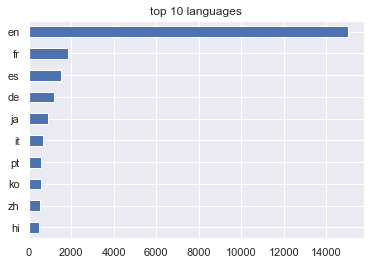

In [232]:
dis.original_language.value_counts()[:10][::-1].plot(kind='barh')
plt.title('top 10 languages')

In [68]:
mean = dis_rate.groupby('year').vote_average.mean()

Text(0.5, 1.0, 'rate probability distribution')

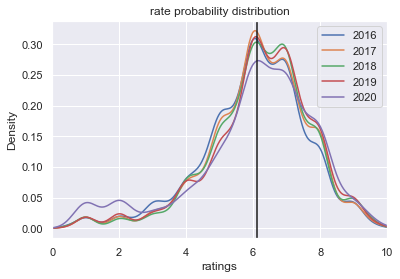

In [251]:
dis.groupby('year').vote_average.plot(kind='kde')
plt.axvline(dis_rate.vote_average.mean(),color='k')
plt.legend()
plt.xlabel('ratings')
plt.xlim(0,10)
plt.title('rate probability distribution')

In [39]:
pd.options.mode.chained_assignment = None

In [32]:
df5 = df5[(df5['budget']!=0) & (df5['revenue']!=0)]

In [7]:
df['year'] = df.release_date.str[:4]
df['profit'] = df.revenue-df.budget
df['ROI'] = 100*df.profit/df.budget

In [8]:
df.head()

,imdb_id,title,genres,popularity,release_date,budget,revenue,vote_average,ROI,year,profit
0,tt8850222,Peninsula,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",800.753,2020-07-15,17000000.0,35878266.0,7.0,111.048624,2020,18878266.0
1,tt4566758,Mulan,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",752.021,2020-09-04,200000000.0,57000000.0,7.2,-71.500000,2020,-143000000.0
2,tt4823776,The SpongeBob Movie: Sponge on the Run,"[{'id': 14, 'name': 'Fantasy'}, {'id': 16, 'na...",1114.882,2020-08-14,60000000.0,4700000.0,8.3,-92.166667,2020,-55300000.0
3,tt8461224,The Tax Collector,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",492.096,2020-08-07,30000000.0,942666.0,6.0,-96.857780,2020,-29057334.0
4,tt8060328,Invasion,"[{'id': 878, 'name': 'Science Fiction'}]",385.953,2020-01-01,8819200.0,32104054.0,7.0,264.024560,2020,23284854.0


In [33]:
df5['year'] = df5.release_date.str[:4]
df5['profit'] = df5.revenue-df.budget

In [37]:
df5['ROI'] = 100*df5.profit/df5.budget

In [30]:
sns.set()

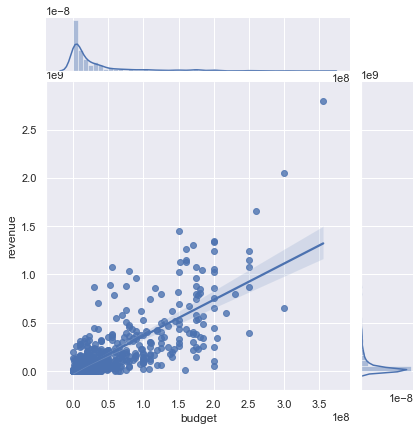

In [34]:
sns.jointplot(x='budget', y='revenue', data=df5, kind="reg")

Text(0.5, 1.0, 'budget vs revenue in yr 2016-2020')

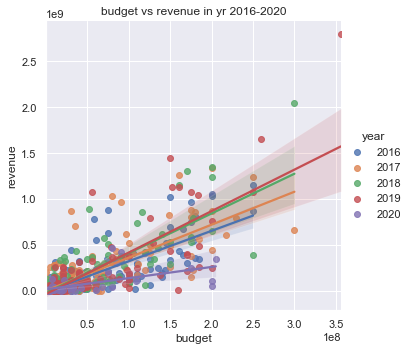

In [35]:
sns.lmplot(x='budget', y='revenue',data=df5, hue='year')
plt.title('budget vs revenue in yr 2016-2020')

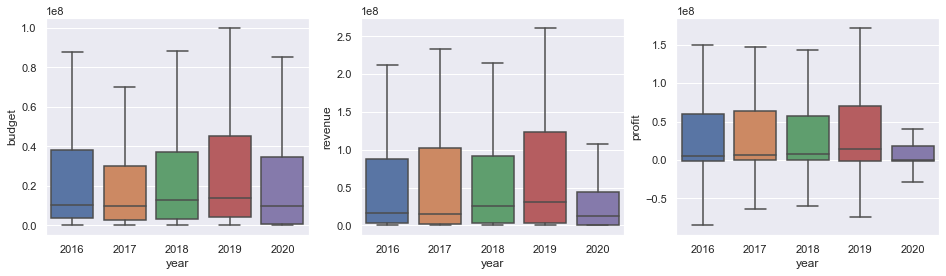

In [141]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
sns.boxplot(x='year',y='budget',data=df5br, ax=ax[0], showfliers = False)
sns.boxplot(x='year',y='revenue',data=df5br, ax=ax[1], showfliers = False)
sns.boxplot(x='year',y='profit',data=df5br, ax=ax[2], showfliers = False)

In [40]:
df['genre'] = None
for i in range(len(df.genres)):    
    ls = df.genres[i].split(',')
    df['genre'][i] = [ls[j][10:-2] for j in range(1,len(ls)-1,2)]
    df['genre'][i].append(ls[-1][10:-3])

In [41]:
gen = pd.DataFrame(df.genre.tolist()).stack()

In [42]:
gen = pd.DataFrame(df.genre.tolist()).stack()
gen.index = gen.index.droplevel(-1)
gen.name = 'gen'
df.join(gen).groupby('gen')

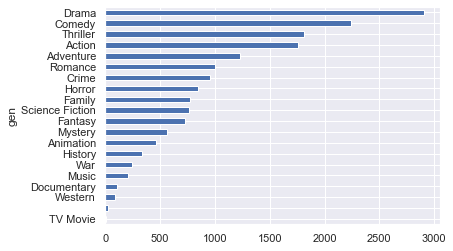

In [43]:
df.join(gen).groupby('gen').size().sort_values().plot(kind='barh')

Text(0.5, 0, 'USD')

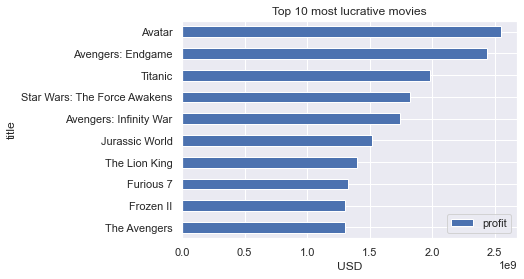

In [78]:
df.sort_values('profit', ascending=False)[:10][::-1].plot(x='title',y='profit',kind='barh')
plt.title('Top 10 most lucrative movies')
plt.xlabel('USD')

In [81]:
df.join(gen).groupby('gen')['profit'].agg(['mean','median','std']).sort_values(by='median', ascending=False)

,mean,median,std
gen,,,
Animation,1.482315e+08,54415416.5,2.376960e+08
Adventure,1.048511e+08,49973072.0,1.283812e+09
Fantasy,1.362291e+08,40270477.0,2.573634e+08
Family,1.159722e+08,36376893.5,2.071723e+08
Action,4.840081e+07,24042224.0,1.081103e+09
Science Fiction,1.177351e+08,22120318.0,2.702383e+08
Comedy,1.074224e+07,15621352.5,1.171935e+09
Romance,4.748634e+07,12657474.0,1.489664e+08
Mystery,3.181006e+07,11726793.0,3.187455e+08


In [160]:
df.join(gen).groupby('gen')['profit'].agg(['mean','median','std']).sort_values(by='mean', ascending=False)

,mean,median,std
gen,,,
Animation,1.482315e+08,54415416.5,2.376960e+08
Fantasy,1.362291e+08,40270477.0,2.573634e+08
Science Fiction,1.177351e+08,22120318.0,2.702383e+08
Family,1.159722e+08,36376893.5,2.071723e+08
Adventure,1.048511e+08,49973072.0,1.283812e+09
Music,5.860595e+07,9208099.0,1.595068e+08
Action,4.840081e+07,24042224.0,1.081103e+09
Romance,4.748634e+07,12657474.0,1.489664e+08
War,4.195495e+07,11234081.0,1.638140e+08


Text(0.5, 1.0, 'ROI')

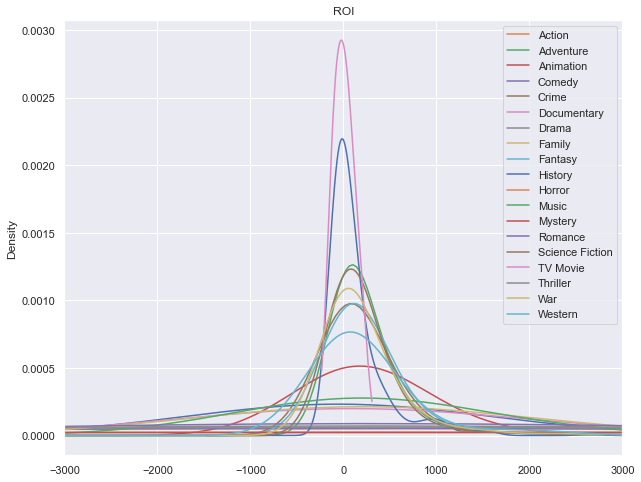

In [159]:
df.join(gen).groupby('gen')['ROI'].plot(kind='kde',figsize=(10,8))
#df[df.genre.str.join(' ').str.contains('Action')]['ROI'].plot(kind='kde',figsize=(10,8),color='k')
plt.legend()
#plt.ylim(0,10)
plt.xlim(-3000, 3000)
plt.title('ROI')

In [123]:
#Sort ROI by median
df.join(gen).groupby('gen')['ROI'].agg(['mean','median','std']).sort_values(by='median', ascending=False)

,mean,median,std
gen,,,
Animation,540.353614,143.369226,2254.095121
Family,694.196425,133.212579,6633.208348
Horror,4091.477401,131.695180,56816.406071
Adventure,305.244503,121.909058,892.056988
Fantasy,325.016719,112.335282,1182.555553
Comedy,1469.814097,108.996928,35342.953536
Romance,927.490320,107.944848,17426.581023
Music,658.903510,107.594937,3767.146580
Mystery,3920.510797,95.285383,62201.029637


In [157]:
#Sort ROI by mean
df.join(gen).groupby('gen')['ROI'].agg(['mean','median','std']).sort_values(by='mean', ascending=False)

,mean,median,std
gen,,,
Horror,4091.477401,131.695180,56816.406071
Mystery,3920.510797,95.285383,62201.029637
Comedy,1469.814097,108.996928,35342.953536
Action,1346.985723,92.558285,30162.929537
Drama,1166.338506,58.709624,30089.399740
Thriller,958.113824,73.846873,24253.906052
Romance,927.490320,107.944848,17426.581023
Documentary,811.869620,-72.998304,4626.407313
Family,694.196425,133.212579,6633.208348


In [52]:
df.join(gen).groupby('gen')['vote_average'].agg(['mean','median','std']).sort_values(by='mean', ascending=False)

,mean,median,std
gen,,,
Documentary,7.105825,7.00,1.101410
History,6.874551,7.00,0.768474
Music,6.858654,6.85,0.870295
War,6.823237,6.90,0.830286
Animation,6.770460,6.80,0.835311
Drama,6.728900,6.80,0.909742
Western,6.713095,6.80,0.930058
Crime,6.538831,6.50,0.890878
Romance,6.530907,6.60,0.937084


# Conclusion

1. The movie industry is highly sabotaged by COVID-19 in 2020, comparing the profit with previous years'. It is not feasbile to start a movie studio right away.
2. Comedy, Thiller and Action movies are dominant in mainstream movie market.
3. Animation, Fantasy and Science Fiction movies are more profitable.
4. The majority movies are rated around 6-7. Documentary, History and War movies are more highly rated.